Initilization

In [1]:
import utils
import torch
import pickle
from embedding import Chemberta_embedding
from autoencoder import Dimensionality_reduction_with_AE
from embedding import Compound
emb = Chemberta_embedding()

/home/kinnunes/.conda/envs/vlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kinnunes/.conda/envs/vlab/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- Th

Reading 50 common solvents from https://organicchemistrydata.org/solvents/

In [2]:
f = open('list_of_solvents.txt', 'r')
solvents = f.readlines()
for i, solvent in enumerate(solvents):
    solvent = solvent.split(' ')
    solvent_len = len(solvent)
    solvent = solvent[0:solvent_len-8]
    solvent = " ".join(solvent)
    if len(solvent) > 0:
        solvents[i] = solvent
print('number of solvents: ', len(solvents))
print(solvents)

number of solvents:  50
['acetic acid', 'acetone', 'acetonitrile', 'benzene', '1-butanol', '2-butanol', '2-butanone', 't-butyl alcohol', 'carbon tetrachloride', 'chlorobenzene', 'chloroform', 'cyclohexane', '1,2-dichloroethane', 'diethylene glycol', 'diethyl ether', 'diglyme (diethylene glycol dimethyl ether)', '1,2-dimethoxy-ethane (glyme, DME)', 'dimethylformamide', 'dimethyl sulfoxide (DMSO)', '1,4-dioxane', 'ethanol', 'ethyl acetate', 'ethylene glycol', 'glycerin', 'heptane', 'hexamethylphosphoramide\n', '(HMPA)', 'hexamethylphosphorous\n', 'triamide (HMPT)', 'hexane', 'methanol', 'methyl t-butyl\n', 'ether (MTBE)', 'methylene chloride', 'N-methyl-2-pyrrolidinone\n', '(NMP)', 'nitromethane', 'pentane', 'petroleum ether (ligroine)', '1-propanol', '2-propanol', 'pyridine', 'Tetrahydrofuran\tC4H8O \t72.106 \t65 \t-108.4 \t0.8833 \tsoluble² \t7.52 \t-14\n', 'toluene', 'triethyl amine', 'water', 'water, heavy', 'o-xylene', 'm-xylene', 'p-xylene']


Encoding solvent names to smiles and smiles to embedding

In [3]:
import pubchempy as pcp
from embedding import Compound

LOAD = True

if LOAD:
    with open('solvent.pickle', 'rb') as handle:
        solvent_dict = pickle.load(handle)

else:
    solvent_dict = {}

    for i, solvent in enumerate(solvents):
        print('solvent:', solvent)
        smiles = utils.name_to_smiles(solvent)
        solvent_name = utils.smiles_to_iupac(smiles, solvent)
        if smiles is None:
            print('Could not find smiles for', solvent)
            continue
        else:
            s = Compound(solvent_name, smiles=smiles)
            s.chemberta_embedding = emb.create_embedding(s.smiles)
            solvent_dict[solvent] = s
            print(s.name, s.smiles)



In [4]:
solvent_dict['ethanol'].chemberta_embedding.shape

torch.Size([3, 768])

In [5]:

with open('solvent.pickle', 'wb') as handle:
    pickle.dump(solvent_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train dimensionality reduction with the data using cls-token embeddings

In [5]:
for i, solvent in enumerate(solvent_dict):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        class_token_embedding = solvent.chemberta_embedding[0,:]
        class_token_embedding = class_token_embedding.reshape(1,-1)
        if i == 0:
            embeddings = class_token_embedding # embeddings into single tensor for training AE
        else:
            embeddings = torch.cat((embeddings, class_token_embedding), 0)

print('embeddings shape: ', embeddings.shape)

#train reduce dimensions
dimensionality_reduction = Dimensionality_reduction_with_AE(embeddings.shape[1], 2)
dimensionality_reduction.train(embeddings, 100)

embeddings shape:  torch.Size([40, 768])
Epoch 1/100, Loss: 0.8500799879431724
Epoch 2/100, Loss: 0.7326344236731529
Epoch 3/100, Loss: 0.7185343235731125
Epoch 4/100, Loss: 0.715408056974411
Epoch 5/100, Loss: 0.7141197443008422
Epoch 6/100, Loss: 0.7130813911557198
Epoch 7/100, Loss: 0.709509140253067
Epoch 8/100, Loss: 0.6966065347194672
Epoch 9/100, Loss: 0.6883975625038147
Epoch 10/100, Loss: 0.6825741186738015
Epoch 11/100, Loss: 0.6806193470954895
Epoch 12/100, Loss: 0.6857540011405945
Epoch 13/100, Loss: 0.6817186295986175
Epoch 14/100, Loss: 0.6781784489750862
Epoch 15/100, Loss: 0.6734054401516915
Epoch 16/100, Loss: 0.6711967766284943
Epoch 17/100, Loss: 0.6715612053871155
Epoch 18/100, Loss: 0.673320172727108
Epoch 19/100, Loss: 0.6743556380271911
Epoch 20/100, Loss: 0.6684368282556534
Epoch 21/100, Loss: 0.6666501820087433
Epoch 22/100, Loss: 0.6645916014909744
Epoch 23/100, Loss: 0.6631336525082588
Epoch 24/100, Loss: 0.6609859019517899
Epoch 25/100, Loss: 0.6597418129444

Text(0.5, 1.0, 'Chemical descriptors in 2D vector space')

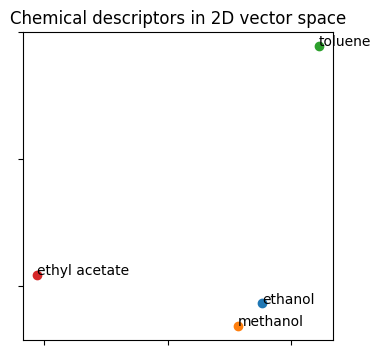

In [34]:
import matplotlib.pyplot as plt
import numpy as np
#import plotly.graph_objects as go
solvents_to_plot = ['ethanol', 'methanol', 'toluene', 'ethyl acetate']
#fig = plt.subplot(2,2,1)
fig = plt.figure(figsize=(4,4))
for i, solvent in enumerate(solvents_to_plot):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding[0,:]
        embedding = embedding.reshape((1,embedding.shape[0]))
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        plt.scatter(x,y, label=solvents_to_plot[i])
        plt.annotate(solvents_to_plot[i], (x,y))
#plt.legend()
plt.xticks(ticks=[-25,-12.5,0],labels = [])
plt.yticks(ticks=[-10,-0,10],labels = [])
plt.title('Chemical descriptors in 2D vector space')
# Show the plot



In [8]:
fig = go.Figure()

for i, solvent in enumerate(solvents_to_plot):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding[-1,:]
        embedding = embedding.reshape((1,embedding.shape[0]))
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        mode='markers',
        name=solvent.name,
        marker=dict(size=10),
        text=solvent.name,
    ))

fig.update_layout(title='2D ChemBERTa descriptors of solvents using END token',)
# Show the plot
fig.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#import plotly.graph_objects as go
solvents_to_plot = ['ethanol', 'methanol', 'toluene', 'ethyl acetate']
#fig = plt.subplot(2,2,1)
fig = plt.figure(figsize=(5,5))
for i, solvent in enumerate(solvents_to_plot):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding[0,:]
        embedding = embedding.reshape((1,embedding.shape[0]))
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        plt.scatter(x,y, label=solvents_to_plot[i])
plt.legend()
plt.title('Chemical descriptors in 2D vector space')
# Show the plot



/tmp/ipykernel_1281093/3690101503.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


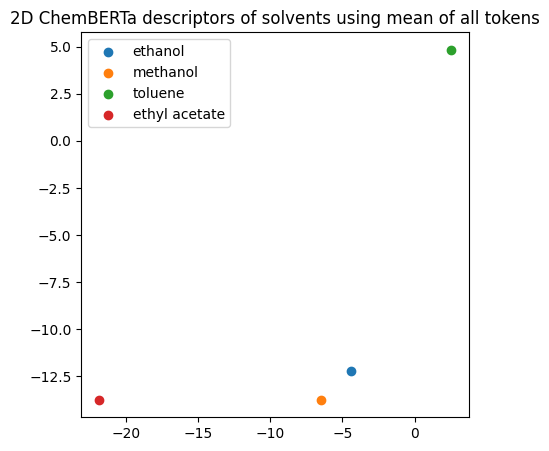

In [21]:
fig = plt.figure(figsize=(5,5))


for i, solvent in enumerate(solvents_to_plot):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding.mean(axis=0)
        embedding = embedding.reshape((1,embedding.shape[0]))
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        plt.scatter(x,y, label=solvents_to_plot[i])
plt.legend()
plt.title('2D ChemBERTa descriptors of solvents using mean of all tokens')
# Show the plot
fig.show()



In [10]:
#find maximum number of tokens
max_tokens = 0
for i, solvent in enumerate(solvent_dict):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding
        if embedding.shape[0]>max_tokens:
            max_tokens = embedding.shape[0]
print(max_tokens)
for i, solvent in enumerate(solvent_dict):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding
        tokens = embedding.shape[0]
        tokens_to_fill = max_tokens-tokens
        fill = torch.zeros(torch.Size([tokens_to_fill, embedding.shape[1]]))
        embedding = torch.cat((embedding, fill), 0)
        embedding = embedding.reshape(1,-1)
        if i == 0:
            embeddings = embedding # embeddings into single tensor for training AE
        else:
            embeddings = torch.cat((embeddings, embedding), 0)

print('embeddings shape: ', embeddings.shape)
#train reduce dimensions
dimensionality_reduction = Dimensionality_reduction_with_AE(embeddings.shape[1], 2)
dimensionality_reduction.train(embeddings, 50)

21
embeddings shape:  torch.Size([40, 16128])
Epoch 1/50, Loss: 0.3727990582585335
Epoch 2/50, Loss: 0.3221457310020924
Epoch 3/50, Loss: 0.3185272619128227
Epoch 4/50, Loss: 0.30768989585340023
Epoch 5/50, Loss: 0.3032715663313866
Epoch 6/50, Loss: 0.29198071397840974
Epoch 7/50, Loss: 0.28443443067371843
Epoch 8/50, Loss: 0.282953187264502
Epoch 9/50, Loss: 0.27236232031136753
Epoch 10/50, Loss: 0.2702293312177062
Epoch 11/50, Loss: 0.274360454082489
Epoch 12/50, Loss: 0.2651530265808105
Epoch 13/50, Loss: 0.27100046873092654
Epoch 14/50, Loss: 0.2654485346749425
Epoch 15/50, Loss: 0.2671373592689633
Epoch 16/50, Loss: 0.2627956746146083
Epoch 17/50, Loss: 0.2729076825082302
Epoch 18/50, Loss: 0.26592066772282125
Epoch 19/50, Loss: 0.2648869311437011
Epoch 20/50, Loss: 0.2656852962449193
Epoch 21/50, Loss: 0.2659184880554676
Epoch 22/50, Loss: 0.26191807352006435
Epoch 23/50, Loss: 0.260818587988615
Epoch 24/50, Loss: 0.26066755037754774
Epoch 25/50, Loss: 0.2579524265602231
Epoch 26

In [11]:
fig = go.Figure()

for i, solvent in enumerate(solvents_to_plot):
    solvent = solvent_dict[solvent]
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding
        tokens = embedding.shape[0]
        tokens_to_fill = max_tokens-tokens
        fill = torch.zeros(torch.Size([tokens_to_fill, embedding.shape[1]]))
        embedding = torch.cat((embedding, fill), 0)
        embedding = embedding.reshape(1,-1)
        #print(embedding.shape)
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        mode='markers',
        name=solvent.name,
        marker=dict(size=10),
        text=solvent.name,
    ))

fig.update_layout(title='2D ChemBERTa descriptors of solvents using concatenated tokens',)
# Show the plot
fig.show()

### old code

In [12]:
solvent_dict['dimethylformamide']

In [13]:
def make_reaction_smiles(reactants, solvents):
    #concat reactant embeddings
    reactant_smiles = []
    for component in reactants.keys():
        component = reactants[component]
        reactant_smiles.append(component.smiles)
    all_reaction_smiles = {}
    for solvent in solvents:
        temp_reactant_smiles = reactant_smiles.copy()
        solvent = solvents[solvent]
        temp_reactant_smiles.append(solvent.smiles)
        if solvent.smiles == None:
            continue
        temp_reactant_smiles = '.'.join(temp_reactant_smiles)
        compound = Compound(solvent.name, temp_reactant_smiles)
        compound.chemberta_embedding = emb.create_embedding(temp_reactant_smiles)
        all_reaction_smiles[solvent.name] = compound

    return all_reaction_smiles
    
    #make reaction embedding


In [14]:
suzuki_reaction_smiles = make_reaction_smiles(suzuki_dict, solvent_dict)

NameError: name 'suzuki_dict' is not defined

In [ ]:

fig = go.Figure()


for i, solvent in enumerate(solvents_to_plot):
    #plot
    try:
        solvent = suzuki_reaction_smiles[solvent]
    except:
        continue
    if solvent.chemberta_embedding is not None:
        embedding = solvent.chemberta_embedding.reshape(1,solvent.chemberta_embedding.shape[0])
        reduced_embedding = dimensionality_reduction.reduce_dimension(embedding)
        x = reduced_embedding[0][0].item()
        y = reduced_embedding[0][1].item()
        
        fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        mode='markers',
        name=solvent.name,
        marker=dict(size=10),
        text=solvent.name,
    ))

fig.update_layout(title='2D ChemBERTa reaction descriptors for in Suzuki Coupling',)
# Show the plot
fig.show()



In [ ]:
suzuki_reaction_smiles['methanol'].smiles

'C1=CC=C(C=C1)I.B(C1=CC=CC=C1)(O)O.CO'